In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

import talib
from mplfinance.original_flavor import candlestick_ohlc

from matplotlib.pylab import date2num

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [3]:
import sys
sys.version
path = sys.path[0] + '/'
path

'/Users/maitreyasinha/IIT-B Course/Data Mining/Portfolio-Analysis/'

In [4]:
cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker']
cols_to_drop = ["Date", "adjclose", "ticker"]
cols_to_keep = [i for i in cols if i not in cols_to_drop]
cols_to_keep

['open', 'high', 'low', 'close', 'volume']

In [5]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["close"], timeperiod=10)
    data["ma30"] = talib.MA(data["close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["close"])
    
    #Get the Average True Range
    data['ATR'] = talib.ATR(data['high'], data['low'], data['close'])
    
    
    
    return data.dropna()

In [6]:
def plot_chart(data, n, ticker, save=False):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index , data["close"], label="Closing" ,linewidth=2,)
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.set_ylabel("MACD")
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel(" RSI (%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Plot ATR --> Volatility
    ax_vol.set_ylabel("Volatility")
    ax_vol.plot(data.index, data["ATR"], label="Average True Range")
    ax_vol.legend()
    
    # Save the chart as PNG
    if save:
        fig.savefig(path + ticker + ".jpeg", bbox_inches="tight", dpi=300)
    
    plt.show()

In [7]:
#2005-07-28
stocks = {"YESBANK.NS" : 0.2, "TATAMOTORS.NS":0.2, "HDFCBANK.NS":0.2, "RELIANCE.NS":0.2,"BAJAJ-AUTO.NS":0.2}
df = None
indices = set([])

for stock in stocks.keys():
    _df = si.get_data(stock)
    _df.dropna(inplace=True)
    if df is None:
        df = _df[cols_to_keep]*stocks.get(stock)
        indices = set(df.index.astype('str').tolist())
    else:
        indices = indices.intersection(set(_df.index.astype('str').tolist()))
        df = df.loc[indices]
        _df = _df.loc[indices]
        df[cols_to_keep] += _df[cols_to_keep]*stocks.get(stock)

df.head()

,open,high,low,close,volume
2018-05-25,1057.869989,1069.270026,1050.130005,1063.439990,7400956.6
2018-10-29,983.199997,999.415009,962.059995,991.340036,16617240.8
2014-06-02,681.450192,695.854805,674.370593,691.323003,7515421.8
2013-03-05,617.161401,625.849210,610.618393,619.274205,7617074.4
2020-10-22,1303.949980,1313.899991,1286.419999,1298.529990,27304677.4


In [8]:
df.index.min(), df.index.max()
_df.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [9]:
df.dropna(inplace=True)
df = df.reset_index()
df.rename(columns = {'index':'Date'}, inplace = True)
# df.drop(["volume"],axis=1,inplace=True)
df.head()

,Date,open,high,low,close,volume
0,2018-05-25,1057.869989,1069.270026,1050.130005,1063.439990,7400956.6
1,2018-10-29,983.199997,999.415009,962.059995,991.340036,16617240.8
2,2014-06-02,681.450192,695.854805,674.370593,691.323003,7515421.8
3,2013-03-05,617.161401,625.849210,610.618393,619.274205,7617074.4
4,2020-10-22,1303.949980,1313.899991,1286.419999,1298.529990,27304677.4


In [10]:
df["Date"].min(), df["Date"].max()

(Timestamp('2012-06-18 00:00:00'), Timestamp('2020-12-14 00:00:00'))

In [11]:
mdf = df[:100]
mdf.head()
print(len(mdf))
mdf.sort_values('Date')

100


,Date,open,high,low,close,volume
86,2012-06-26,497.679001,503.738000,495.296999,500.837396,4669506.8
37,2012-08-02,515.080199,519.618190,507.422594,515.838405,3220042.2
81,2012-08-10,536.959404,539.847203,530.368199,533.824789,6412833.6
97,2012-08-28,544.546808,545.710811,532.577998,536.565404,5385202.6
69,2012-09-10,536.371602,546.030798,534.318999,542.765797,4349420.0
...,...,...,...,...,...,...
15,2020-06-29,1143.650010,1164.129995,1138.320010,1156.850014,17882715.4
23,2020-07-16,1193.720004,1201.739999,1172.949966,1194.080024,24602950.2
4,2020-10-22,1303.949980,1313.899991,1286.419999,1298.529990,27304677.4
33,2020-11-17,1334.390010,1344.109977,1305.729985,1323.899971,62586412.0


,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR
Date,,,,,,,,,,,,
2012-08-02,515.080199,519.618190,507.422594,515.838405,3220042.2,3.165544,-0.362080,3.527625,505.899880,500.317539,64.838114,11.590482
2012-08-03,512.061009,516.168790,507.133200,513.588004,5201908.4,3.573758,0.425087,3.148670,506.527801,500.866452,62.135523,11.407990
2012-08-06,519.479205,528.380006,518.205194,525.871790,9010146.6,4.832759,1.306622,3.526138,509.333039,501.820465,69.587327,11.649705
2012-08-07,527.209999,541.242604,524.404599,533.880203,8202085.0,6.402930,2.325883,4.077047,512.916179,502.921892,73.279433,12.020298
2012-08-08,534.225198,540.492406,530.710211,537.157410,6856643.8,7.821583,3.425023,4.396560,516.860921,504.172926,74.636409,11.860433


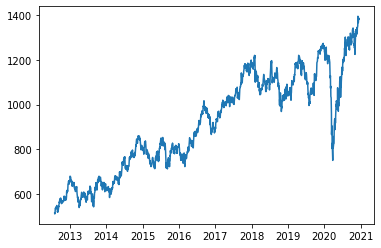

In [12]:
if "Date" in df.columns:
    df.sort_values("Date", inplace=True)
    df= df.set_index("Date")
#     df.index = df.index.sort_values()
    split_date = '2020-01-01'

    df = get_indicators(df)
    df.dropna(inplace=True)
    df_data_training = df[df.index < split_date]
    df_data_test = df[df.index >= split_date]
    
plt.plot(df.index,df["open"])

df.head()

In [13]:
df.index = df.index.sort_values()
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR
Date,,,,,,,,,,,,
2012-08-02,515.080199,519.618190,507.422594,515.838405,3220042.2,3.165544,-0.362080,3.527625,505.899880,500.317539,64.838114,11.590482
2012-08-03,512.061009,516.168790,507.133200,513.588004,5201908.4,3.573758,0.425087,3.148670,506.527801,500.866452,62.135523,11.407990
2012-08-06,519.479205,528.380006,518.205194,525.871790,9010146.6,4.832759,1.306622,3.526138,509.333039,501.820465,69.587327,11.649705
2012-08-07,527.209999,541.242604,524.404599,533.880203,8202085.0,6.402930,2.325883,4.077047,512.916179,502.921892,73.279433,12.020298
2012-08-08,534.225198,540.492406,530.710211,537.157410,6856643.8,7.821583,3.425023,4.396560,516.860921,504.172926,74.636409,11.860433


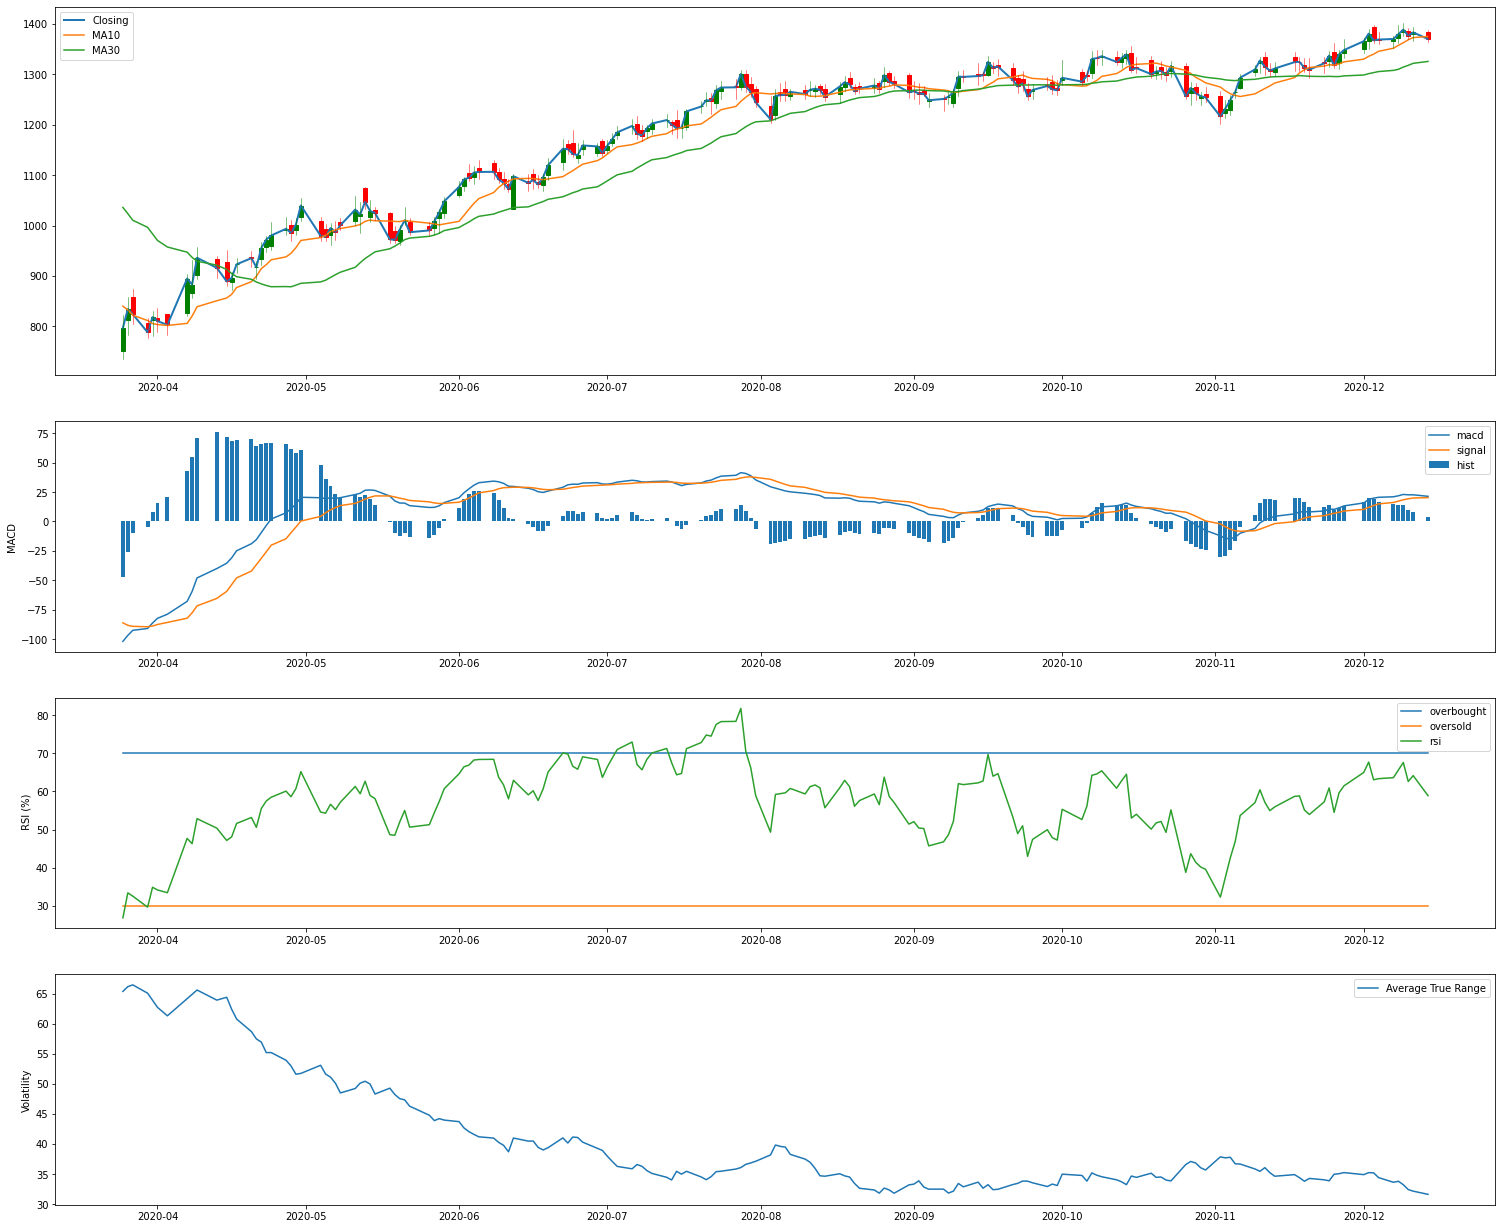

In [14]:
# _df = df.set_index("Date")
_df = get_indicators(df)
plot_chart(_df, 180, 'Custom')

In [15]:
df_data_training.head()
print("Training Size : {}, Test Size : {}".format(len(df_data_training), len(df_data_test)) )

Training Size : 1818, Test Size : 238


In [16]:
data_training = df_data_training.copy()
data_training.dropna(inplace=True)

## Scaler

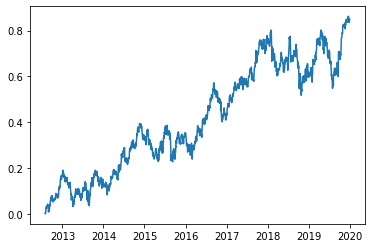

In [17]:
scaler = MinMaxScaler()
scaler.fit(df)

training_Dataset = scaler.transform(data_training)
_scale = 1/scaler.scale_[0]
plt.plot(data_training.index, training_Dataset[:,0])

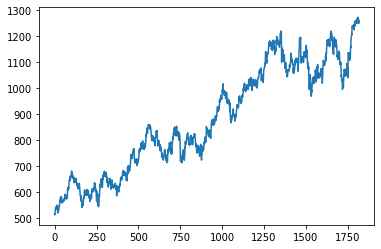

In [18]:
_df = scaler.inverse_transform(training_Dataset)
plt.plot(_df[:,0])
# _df

1818 2056


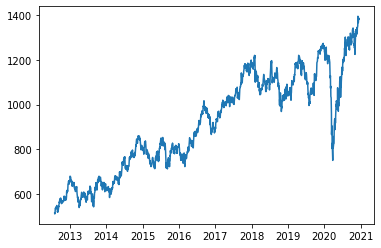

In [19]:
print(len(data_training), len(df))
plt.plot(df.index,df["open"])

## Training Pipeline

In [20]:
training_window = 60
prediction_window = 14
X_train = []
y_train = []
for i in range(training_window, training_Dataset.shape[0]-prediction_window):
    X_train.append(training_Dataset[i-training_window:i])
    y_train.append(training_Dataset[i+prediction_window,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [21]:
print("Shape of X is : {}, Shape of Y is : {}".format(X_train.shape,y_train.shape))

Shape of X is : (1744, 60, 12), Shape of Y is : (1744,)


In [22]:
print("Shape of data_training.index", data_training.index[training_window:].shape)

Shape of data_training.index (1758,)


In [23]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if logs["loss"] < 0.00125:
            print("\nFinal Loss : {}".format(logs["loss"]))
            self.model.stop_training = True

In [24]:
model = Sequential([
    LSTM(units=120, activation='relu', return_sequences = True, input_shape = (60,12)),
    Dropout(0.2),
    LSTM(units=90, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=80, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=70, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 120)           63840     
_________________________________________________________________
dropout (Dropout)            (None, 60, 120)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 90)            75960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 90)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            54720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                4

In [25]:
model_name = path + "daily_predictor.hdf5"
# model.save(model_name)
model.load_weights(model_name)

In [26]:
model.compile(optimizer= tf.optimizers.RMSprop() , loss= tf.losses.MeanSquaredError())
X_train.shape, y_train.shape
model.fit(X_train,y_train, epochs=50, callbacks = CustomCallback())

Epoch 1/50
55/55 [==============================] - 6s 105ms/step - loss: 0.0026
Epoch 2/50
55/55 [==============================] - 5s 90ms/step - loss: 0.0023
Epoch 3/50
55/55 [==============================] - 5s 89ms/step - loss: 0.0020
Epoch 4/50
55/55 [==============================] - 5s 86ms/step - loss: 0.0020
Epoch 5/50
55/55 [==============================] - 5s 86ms/step - loss: 0.0021
Epoch 6/50
55/55 [==============================] - 5s 85ms/step - loss: 0.0017
Epoch 7/50
55/55 [==============================] - 5s 85ms/step - loss: 0.0019
Epoch 8/50
55/55 [==============================] - 5s 86ms/step - loss: 0.0017
Epoch 9/50
55/55 [==============================] - 5s 87ms/step - loss: 0.0017
Epoch 10/50
55/55 [==============================] - 5s 87ms/step - loss: 0.0017
Epoch 11/50
55/55 [==============================] - 5s 92ms/step - loss: 0.0016
Epoch 12/50
55/55 [==============================] - 5s 89ms/step - loss: 0.0021
Epoch 13/50
55/55 [=================

In [27]:
test_pred = model.predict(X_train)
model.evaluate(X_train, y_train)
test_pred
test_pred = test_pred * _scale
y_train = y_train * _scale

# test_pred.shape

55/55 [==============================] - 1s 24ms/step - loss: 7.0279e-04


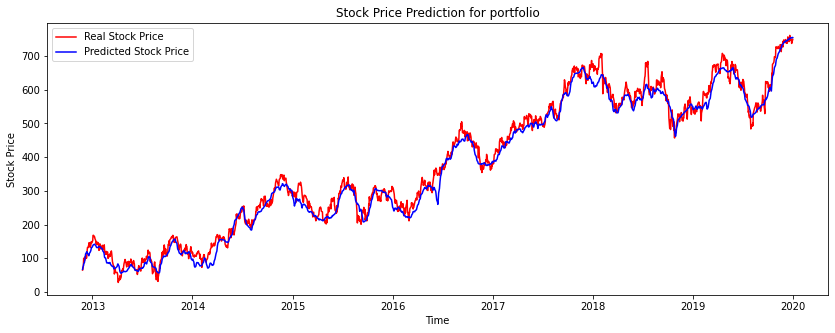

In [28]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(data_training.index[training_window+prediction_window:], y_train, color = 'red', label = 'Real Stock Price')
plt.plot(data_training.index[training_window+prediction_window:], test_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for portfolio')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,2000)
# plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/training_output.jpeg", dpi=300)
plt.show()

In [29]:
past_60_days = df_data_training.tail(training_window)
df_data_test.head(4)

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR
Date,,,,,,,,,,,,
2020-01-01,1241.839994,1247.009995,1229.660016,1233.880009,27363888.0,3.000705,7.269832,-4.269127,1255.782993,1253.348995,42.493767,20.573217
2020-01-02,1235.549990,1248.929990,1226.810011,1236.830009,38230051.6,1.576842,6.131234,-4.554392,1253.397997,1253.132329,44.208076,20.683700
2020-01-03,1236.189989,1239.760004,1217.539995,1223.160020,31569180.8,-0.647173,4.775553,-5.422725,1248.790001,1252.319663,38.483083,20.793436
2020-01-06,1217.550000,1219.810034,1198.420010,1202.179970,29702324.6,-4.055882,3.009266,-7.065148,1242.469999,1251.120661,31.698347,21.075334


In [30]:

df_test = past_60_days.append(df_data_test).sort_index()
df_test.dropna(inplace=True)
df_test.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR
Date,,,,,,,,,,,,
2019-10-01,1134.700000,1147.769990,1108.890015,1122.200015,173463121.4,19.226641,14.566661,4.659980,1113.142601,1081.084265,59.522002,30.967373
2019-10-03,1117.759991,1133.029990,1105.600005,1119.480000,132846895.4,18.381696,15.329668,3.052028,1119.841001,1082.940398,58.512182,30.714703
2019-10-04,1127.870010,1134.579991,1100.780006,1104.629996,112950881.2,16.325609,15.528856,0.796752,1126.358997,1084.266398,53.205056,30.935080
2019-10-07,1107.079966,1121.610015,1099.389985,1110.490010,81378225.8,14.996132,15.422311,-0.426179,1125.968999,1085.772865,54.941831,30.312576
2019-10-09,1111.749986,1128.399995,1103.349999,1121.780025,81061969.6,14.684252,15.274700,-0.590448,1124.648005,1088.218532,58.163495,29.936678


In [31]:
inputs = scaler.transform(df_test)
inputs

array([[0.70593271, 0.7141488 , 0.6970273 , ..., 0.69072101, 0.69399958,
        0.36260412],
       [0.68672655, 0.69748234, 0.69327873, ..., 0.69307125, 0.68014589,
        0.35806382],
       [0.69818904, 0.69923492, 0.68778691, ..., 0.69475023, 0.6073376 ,
        0.36202383],
       ...,
       [0.99051029, 0.98891917, 0.99324347, ..., 0.99014897, 0.73653444,
        0.38875664],
       [0.98344692, 0.99309143, 0.98968861, ..., 0.99523192, 0.75770376,
        0.38400403],
       [0.98835611, 0.98543665, 0.98645275, ..., 1.        , 0.68547013,
        0.37454673]])

In [32]:
X_test = []
y_test = []

for i in range(training_window, inputs.shape[0]-prediction_window):
    X_test.append(inputs[i-training_window:i])
    y_test.append(inputs[i+prediction_window, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((224, 60, 12), (224,))

In [33]:
y_pred = model.predict(X_test)
y_pred.shape

(224, 1)

In [34]:
scaler.scale_

array([1.13377530e-03, 1.13069576e-03, 1.13938065e-03, 1.14299824e-03,
       4.28766698e-09, 6.91456532e-03, 7.84613655e-03, 2.08577301e-02,
       1.18106666e-03, 1.26619937e-03, 1.37189709e-02, 1.79692145e-02])

In [35]:
y_pred = y_pred*_scale
y_test = y_test*_scale
y_pred.shape

(224, 1)

In [36]:
model.evaluate(X_test,  y_test)

7/7 [==============================] - 0s 44ms/step - loss: 454349.3125


454349.3125

In [37]:
y_test.max()

882.0089809417725

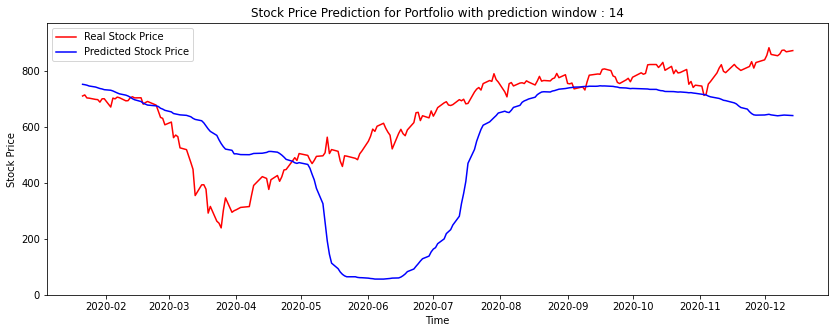

In [38]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(df_test.index[training_window+prediction_window:], y_test, color = 'red', label = 'Real Stock Price')
plt.plot(df_test.index[training_window+prediction_window:], y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for Portfolio with prediction window : '+ str(prediction_window))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
y_test
plt.ylim(0,y_test.max()*1.1)
# plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/test_output.jpeg", dpi=300)
plt.show()